# Packages

In [2]:
"""Importing some necessary packages for the project"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from matplotlib import rcParams
import plotly.graph_objs as go
import plotly.figure_factory as ff
import seaborn as sns
import plotly.tools as tls
from plotly.offline import init_notebook_mode
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz #Exports decision trees to dot file
from sklearn.model_selection import train_test_split
from plotly.offline import iplot
from IPython.display import Image
import warnings
import math

# importing a module I've created that contains some constants
from modules import encoding_dictionaries as encodeDict

"""
Setting a seed for random numbers for reproductibily of the results.
Please note that, for some models ex. deep learning we have to set again
a seed proper to the model.
"""
np.random.seed(42)

init_notebook_mode(connected = True)
%matplotlib inline
warnings.filterwarnings('ignore') # Ignoring the warnings

"""Setting of properties of figures"""
plt.style.use('ggplot')
params = {'legend.fontsize': 'large',
          'figure.figsize': (18,5),
          'font.size': 12,
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
           'axes.titlesize' :'large',
          'axes.grid': False
          #'axes.prop_cycle': {'color': ['cyan', 'orange', 'yellow']}
          
         }
rcParams.update(params)
paired_colors = sns.color_palette("Paired", 2)
colors = sns.color_palette("hls", 30)
plt.style.use('dark_background')
colors = ['c', 'y', 'k', 'm']

"""Setting som constats"""
FIGURES_SAVING_PATH = './img/figures' # Path in which figures will be saved
FIGURE_SUPTITLE_PARAMS = dict(y=1.1, size=18, weight='bold') # This constant will be used suptitles properties.

# Reading the data

In [60]:
df = pd.read_csv('./data/merged_r5_data.csv', low_memory=False)

In [4]:
df.shape

(51587, 348)

## Data cleansing: Part 1

In this first part of the data cleansing we will drop unecessary variablesand those containg high percentage of missing data.

In [59]:
"""Defining helper function for data cleansing"""
def clean_data(df, missing_values_threshol=50, show_dropped_cols=True):
    # Taking all variables before Q105 included
    df_ = df.loc[:, :'Q105']
    to_drop_1 = ['COUNTRY', 'COUNTRY.BY.REGION.NO', 'COUNTRY.BY.REGION', 'RESPNO', 'DATEINTR', 'STRTIME','THISINT', 
                 'PREVINT', 'ENDTIME','LENGTH', 'CALLS'] # Dropping unecessary variables from the one selected before
    to_drop_2 = [ col for col in df.columns if 'NOCALL' in col] # Dropping columns containing 'NOCALL'
    drop_cols = to_drop_1 + to_drop_2
    df_ = df_.drop(drop_cols, axis=1)
    #defining a lambda function that computes the percentage of missing
    percentage_missing_data = lambda x: 100*(x.isna().sum() / x.shape[0]).round(2) 
    dropped_cols = pd.DataFrame(columns=['Variables', 'Percentage missing data'])
    n_dropped = 0 # Number od missing that will be dropped
    for col in list(df_):
        pmissing = percentage_missing_data(df_[col])
        if pmissing >= missing_values_threshol:
            dropped_cols.loc[n_dropped, :] = [col, pmissing]
            df_.drop(col, axis=1, inplace=True)
            n_dropped += 1 
    if show_dropped_cols:
        print('Dropped columns not satisfying the missing data treshold are:')
        print(dropped_cols)
    return df_

In [61]:
df = clean_data(df.copy())

Dropped columns not satisfying the missing data treshold are:
        Variables Percentage missing data
0         Q2OTHER                      93
1        Q11OTHER                      93
2        Q12OTHER                      93
3        Q31D_ARB                      88
4        Q41A_ARB                      88
5        Q41B_ARB                      88
6        Q41C_ARB                      88
7        Q41D_ARB                      88
8        Q43A_ARB                      88
9        Q43B_ARB                      88
10       Q43C_ARB                      88
11       Q43D_ARB                      88
12       Q43E_ARB                      88
13       Q47F_ARB                      88
14       Q47G_ARB                      88
15       Q47H_ARB                      88
16       Q47I_ARB                      88
17    Q63PT1OTHER                      97
18    Q63PT2OTHER                      97
19    Q63PT3OTHER                      97
20           Q70C                      51
21       Q73A_

# Visualisation

In [7]:
"""Defining a helper function for computing age groups"""
def get_age_groups(ages):
    cat_ages = []
    for i in range(ages.shape[0]):
        if ( ages[i] < 25):
            cat_ages.append('<25')
        if (25 <= ages[i] and ages[i] <= 35):
                cat_ages.append('25-35')
        if ( 36 <= ages[i] and ages[i] <= 45):
                cat_ages.append('36-45')
        if (46 <= ages[i] and ages[i] <= 55):
                cat_ages.append('46-55')
        if (56 <= ages[i] and ages[i] <= 65):
                cat_ages.append('56-65')
        if (66 <= ages[i] and ages[i] <= 75):
                cat_ages.append('66-75')
        if ( ages[i] >= 76):
                cat_ages.append('>76')
    return  pd.Series(cat_ages)
    
"""Defining a helper function for variables encoding"""
def encode_col_values(col, dic):
    return col.map(dic)


In [8]:
"""Defining a helper function for data visualisation"""
def visualize(list_cols_values, labels, figName, direction='H', saveFig=True):
    fig = plt.figure(figsize=(12,4))
    n_cols = len(list_cols_values)
    n_rows = 1
    for i, col_values in enumerate(list_cols_values):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        count_col_values = col_values.value_counts().sort_values()
        if direction == 'H': count_col_values.plot(kind='barh', ax=ax, label=labels[i], color=colors[i])
        else: count_col_values.plot(kind='bar', ax=ax, label=labels[i], color=colors[i])
        annotate(count_col_values, ax, direction)
    fig.tight_layout()
    fig.suptitle(figName, **FIGURE_SUPTITLE_PARAMS)
    fig.legend()
    if saveFig: savefig(fig, figName)

"""Defining a helper function for annotating figures"""            
def annotate(count_col_values, ax, direction): 
    counts_percentage = 100*count_col_values.apply(lambda x: x / count_col_values.sum()).round(2)
    for j in range(count_col_values.shape[0]):
        percentage = counts_percentage[j]
        if direction == 'H': ax.text(count_col_values[j], j, str(int(percentage)) + '%')
        else: ax.text(j, count_col_values[j], str(int(percentage)) + '%', weight='bold', size=14)

"""Defining a helper function for saving figures"""            
def savefig(fig, name, path=FIGURES_SAVING_PATH):
    full_path = f'{path}/{name}.png'
    fig.savefig(full_path)

We will visualize 4 variables distribution of the data as for:
* Age: Q1
* Countries: COUNTRY_ALPHA
* Sex: Q101
* Education level: Q97

In [9]:
"""Selection variables to visualize"""
ages = df.Q1
age_groups = get_age_groups(ages)
countries = df.COUNTRY_ALPHA.map(encodeDict.COUNTRIES_DICTIONARY)
sex = df.Q101.map(encodeDict.SEX_DICTIONARY)
education = df.Q97.map(encodeDict.EDUCATION_DICTIONARY)
age_groups_sex = [age_groups, sex]
age_groups_sex_labels = ['Age groups', 'Sex',]
countries_label = ['Countries']
education_label = ['Education']

Please note that in the visualization figures the percentages are rounded, so the sum might not equal 100.

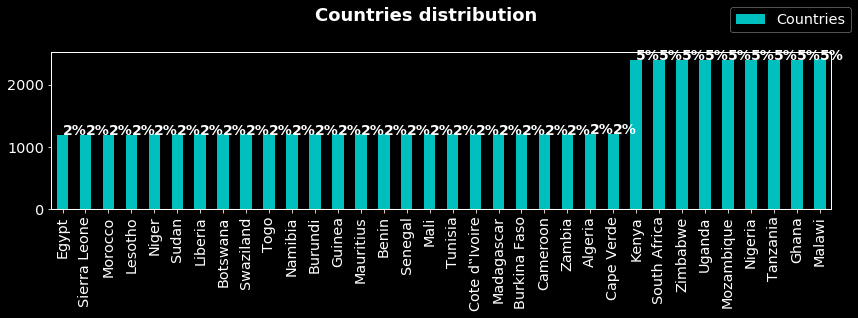

In [10]:
# Visualization of Country distribution
visualize([countries], countries_label, 'Countries distribution', direction='V')

From the figure above, one could note that there are two groups of countries that have approximately the same repartition. The one with a ratio of 5% (Kenya, South Africa, Ghana, Tanzania, Mozambique, Uganda, Nigeria and Malawi) and the other countries having a ratio of 2%.

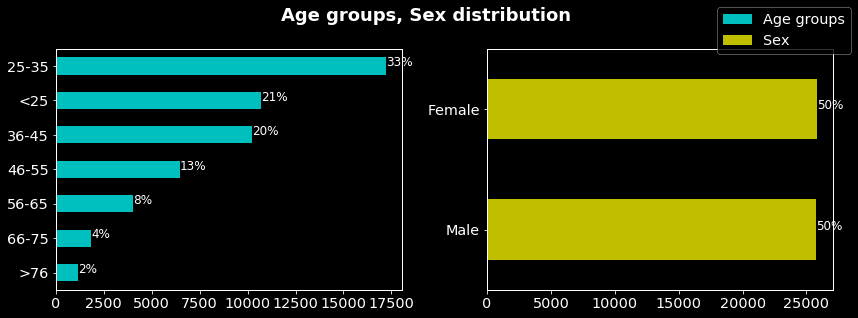

In [11]:
# Visualization of Country age groups and sex distribution
visualize(age_groups_sex, age_groups_sex_labels, 'Age groups, Sex distribution')

From the figure above, one could see that the sex is equaly distributed contrary to the age groups in which the age group 25-35 is the most represented and >76 the least.

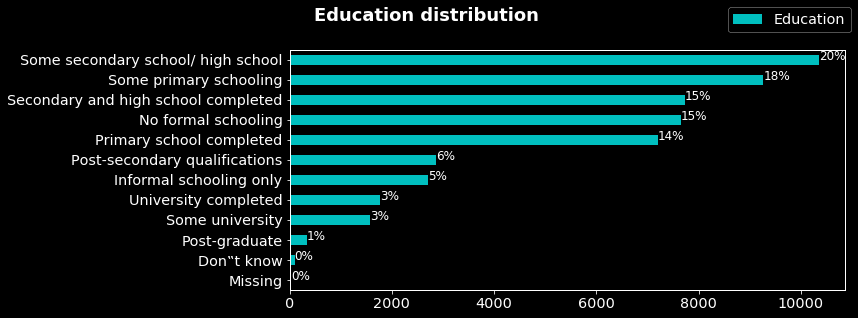

In [12]:
# Visualization of education level distribution
visualize([education], education_label, 'Education distribution')

20% of people in the sample accomplished some secondary and high school and only 3% achieved a complete university curriculum.

In [13]:
"""
Defining a helper function for computing the most type of bribe in each country.
The computation is as follow for each types:
For each country compute the compute the frecencies of the answers:
- Never
- Once or twice
- A few times
- Often
- No experience with this in the past year

Of each of the bribe type:
- Document or permit
- water or sanitation services
- Treatment at local health clinic or hospital
- Avoid problem with police
- School placement,
- Election incentives
"""
def get_most_corruption_type_by_country(df_bribes, countries):
    df_bribes.columns = ['Document or permit','water or sanitation services','Treatment at local health clinic or hospital',
                        'Avoid problem with police','School placement','Election incentives']
    most_corruption_type = []
    for country in countries.unique():#Looping over countries
        max_ = 0.0
        type_ = ''
        for col in df_bribes.columns:#Looping over bribes types and getting the max of percentage
            counts = df_bribes.loc[countries == country,col].value_counts()
            if 'At least once' in counts.index:
                n_at_least_once = counts['At least once']
                pertcent = 100*np.round(n_at_least_once/counts.sum(),3)
                if pertcent > max_:
                    max_ = pertcent
                    type_ = col
        most_corruption_type.append({'country':country,'type':type_,'percentage': max_})
    return most_corruption_type


"""Defining a helper function to plot a choropleth of the most frequent types of bribes by country"""
def plot_choropleth(df,z, layout_title, colorscale, colorbar_title, tickvals, ticktext, tickmode='array', color='rgb(255,255,255)', save_as = 'choropleth'):
    data = [ dict(
            type='choropleth',
            autocolorscale = False,
            locations = df.country,
            z = z,
            locationmode = "country names",
            text = df.percentage,
            hoverinfo = 'location+text',
            colorscale = colorscale,
            marker = dict(
                line = dict (
                    color =color ,
                    width = 2
                ) ),
            colorbar = dict(
                title = colorbar_title,
                tickmode = tickmode,
                tickvals = tickvals,
                ticktext =ticktext 
            ) )]
    layout = dict(
        title =layout_title,
        geo = dict(
            scope='africa',
            projection=dict( type= "mercator" )
             )
    )
    
    fig = dict( data=data,layout = layout )
    iplot( fig )

### Visualisation of most frequent types of bribes by country

Questions Q61A to Q61F refer to the types of bribes the interviewed persons experienced in the past. Here are the descriptions of each question:
* Q61A: In the past year, how often, (if ever, have you had to pay a bribe, give a gift, or do a favor to
       government officials in order to: Get a document or a permit)?
* Q61B: In the past year, how often, if ever, have you had to pay a bribe, give a gift, or do a favor to
    government officials in order to: Get water or sanitation services?
* Q61C: In the past year, how often, if ever, have you had to pay a bribe, give a gift, or do a favor to
    government officials in order to: Get treatment at a local health clinic or hospital?
* Q61D: In the past year, how often, if ever, have you had to pay a bribe, give a gift, or do a favor to
    government officials in order to: Avoid a problem with the police (like passing a checkpoint or avoiding a
    fine or arrest)?
* Q61E: In the past year, how often, if ever, have you had to pay a bribe, give a gift, or do a favor to
    government officials in order to: Get a place in a primary school for a child?
* Q61F: And during the last national election in 20xx, how often, if ever did a candidate or someone
    from a political party offer you something, like food or a gift or money, in return for your vote?

In [14]:
"""Selecting variables Q61A to Q61F, replacing the missing data by the mode of each column, and encode the responses"""
df_bribes = df.loc[:,'Q61A':'Q61F'].copy()
df_bribes = df_bribes.fillna(df_bribes.mode().loc[0]).replace(encodeDict.RESPONSES_EXPERIENCE_WITH_BRIBERIES, value=None)
df_bribes = df_bribes.replace({'Once or twice': 'At least once','A few times': 'At least once', 'Often': 'At least once'}, value=None)

In [15]:
"""Getting a data frame containing the most frequent type of bribe by country"""
types = get_most_corruption_type_by_country(df_bribes, countries)
df_most_corruption_type_by_country = pd.DataFrame(types)
encode_types = {'Avoid problem with police':0, 'Document or permit':1, 'Election incentives':2,
                'Treatment at local health clinic or hospital':3}
df_most_corruption_type_by_country.type.replace(encode_types, inplace = True)

In [16]:
"""
Uncomment to plot the choropleths
# Plotting the data frame obtained above
plot_choropleth(df = df_most_corruption_type_by_country, colorscale = 'RdBu', z=df_most_corruption_type_by_country.type,
                layout_title='Most frequent types of bribes in Africa', colorbar_title="Type of bribes", tickvals=list(encode_types.values()),
                ticktext =list(encode_types.keys()))

# Plotting the data frame obtained
plot_choropleth(df = df_most_corruption_type_by_country, z = df_most_corruption_type_by_country.percentage, layout_title = 'Bribes frequences',colorscale = 'Rainbow',
               colorbar_title = "Frequence", tickmode = 'auto',tickvals = list(encode_types.values()),
                ticktext =list(encode_types.values()))
                
"""                

'\nUncomment to plot the choropleths\n# Plotting the data frame obtained above\nplot_choropleth(df = df_most_corruption_type_by_country, colorscale = \'RdBu\', z=df_most_corruption_type_by_country.type,\n                layout_title=\'Most frequent types of bribes in Africa\', colorbar_title="Type of bribes", tickvals=list(encode_types.values()),\n                ticktext =list(encode_types.keys()))\n\n# Plotting the data frame obtained\nplot_choropleth(df = df_most_corruption_type_by_country, z = df_most_corruption_type_by_country.percentage, layout_title = \'Bribes frequences\',colorscale = \'Rainbow\',\n               colorbar_title = "Frequence", tickmode = \'auto\',tickvals = list(encode_types.values()),\n                ticktext =list(encode_types.values()))\n                \n'

In [17]:
%%html
Please note that the two choropleth figures will not be displayed as output once the notebook in imported, so I'll put them manually.
<img src='https://raw.githubusercontent.com/abdjiber/Election-corruption-in-Africa/master/img/figures/choropleth_types_bribes.png'>
<img src='https://raw.githubusercontent.com/abdjiber/Election-corruption-in-Africa/master/img/figures/choropleth_types_bribes_frequencies.png.png'>

## data cleansing part 2 : Preparing data for modeling

Here we will set the target variable (Q61F), encode it to string for future plotting labels and drop it from the data frame. We will also fill the missing data by the mode of each variable.

In [18]:
target = df['Q61F'] # Setting the target variable
df = df.fillna(df.mode().loc[0]) # Filling missing
"""
Getting a mask of target values different of -1, 998 and 9 which correspond 
respectively to missing, reused to answer and don't know
"""
mask = (target != -1) & (target != 998) & (target != 9) 
target = target[mask]
target_encoded = target.replace(encodeDict.RESPONSES_EXPERIENCE_WITH_BRIBERIES) # Encoding int values to string
df = df.loc[target.index]
del df['Q61F'] # Deleting the target variable from the data.

In [19]:
target_2_classes = target.replace({0:0, 1:1, 2:1, 3:1})

In [20]:
"""Scaling the data to the range [0, 1]"""
scale = MinMaxScaler()
scale.fit(df)
df_scaled = pd.DataFrame(scale.transform(df), columns=list(df))

# Modeling

## Unsupervised learning

In the unsupervised learning part, we will be using principal components analysis (PCA), and K-means.

In [21]:
from matplotlib.colors import ListedColormap, cnames

In [22]:
"""Defining a helper function for plotting PCA"""
def plot_pca(data, labels, explained_variance, components, columns, figName, plot_correlation_circle_cyle=True, saveFig=True):
    fig = plt.figure(figsize = (10, 4))
    ax1 = fig.add_subplot(1, 1, 1)
    #ax2 = fig.add_subplot(1, 2, 2)
    colors = ['cyan', 'yellow', 'orange', 'darkgreen']
    #plot_correlation_circle(components, columns, ax2)
    for i, lab in enumerate(labels.unique()):
        ax1.scatter(data[labels == lab,0], data[labels == lab, 1], label = lab, color=colors[i], s=60)
    ax1.set_xlabel('Explained variance ' + str(int(100*explained_variance[0])) + '%')
    ax1.set_ylabel('Explained variance ' + str(int(100*explained_variance[1])) + '%')
    ax1.axhline(y=0, color='grey')
    ax1.axvline(x=0, color='grey')
    ax1.set_title('Data projection')
    fig.suptitle(figName, **FIGURE_SUPTITLE_PARAMS)
    fig.legend(loc='bottom')
    fig.tight_layout()
    savefig(fig, figName)

"""Defining a helper function for plotting the correlation circle of the PCA results"""
def plot_correlation_circle(components, columns, ax):
    ax.scatter(components[:,0],components[:, 1], s=60, color='tomato')
    for i in range(len(columns)):
        x = components[i,0]
        y = components[i, 1]
        ax.text(x, y, columns[i])
    
    """
    The two lines code below which draw a circle are commented for figures clarity,
    please uncomment if you want to display the circle
    """
    #t = np.linspace(0, np.pi*2,100)
    #ax.plot(np.cos(t), np.sin(t), linewidth=1) #draw a circle
    ax.axhline(y=0, color='grey')
    ax.axvline(x=0, color='grey')
    ax.set_title('Correlation circle')

### PCA

In [23]:
Pca = PCA(n_components=2)
pca = Pca.fit_transform(df_scaled)
components = Pca.components_.T;columns = df.columns; explained_variance_ratio = Pca.explained_variance_ratio_.round(2)

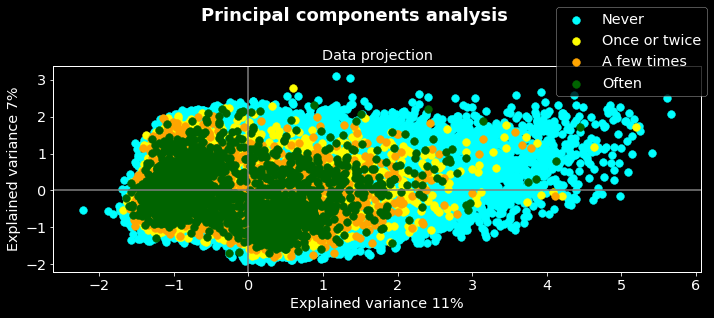

In [24]:
plot_pca(pca, target_encoded, explained_variance_ratio, components, columns, figName = 'Principal components analysis')

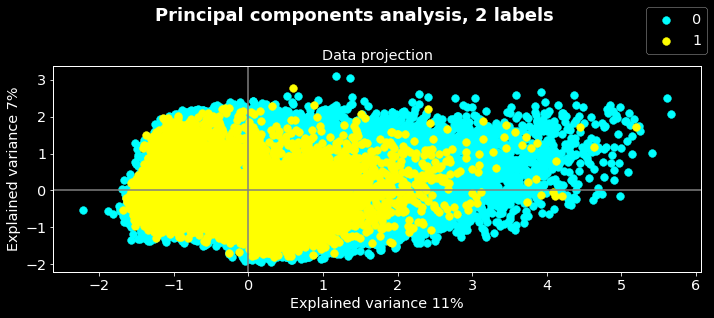

In [25]:
plot_pca(pca,target_2_classes , explained_variance_ratio, components, columns, figName = 'Principal components analysis, 2 labels')

### K-means

In [26]:
from sklearn.cluster import KMeans # Importing the K-means class from scikit-learn

The elbow criterion helps to determine the optimal number of clusters when using K-means. 
The process is as follow:
1. Set a list of number of clusters n1, n2, ...
2. Run the K-means using each n
3. For each n, compute the inertia (cost of the objective function)
4. Plot the list on inertia against the list of n
3. The optimal number of clusters will be the n giving an elbow.

In [27]:
"""Defining a helper function fot the elbow experience"""
def elbow(data):
    n_clusters = [2, 3, 4, 5, 6, 7, 8]
    cost = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_jobs=-1, n_clusters=n_cluster)
        pred_labs = kmeans.fit_predict(data)
        cost.append(kmeans.inertia_)
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,1,1)
    ax.plot(n_clusters, cost, marker='*')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Inertia')
    #ax.set_xticks(range(4), n_clusters)

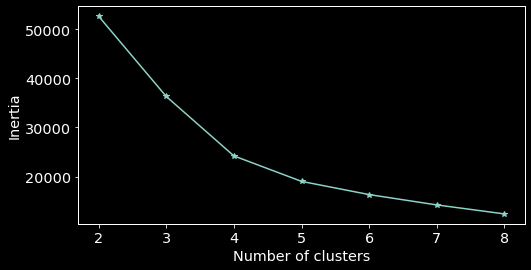

In [28]:
elbow(pca)

From the figure above, the optimal number of clusters is 4. So we will run the K-means with 4 clusters.

In [29]:
"""Defining a helper function for plotting a two dimensions data"""
def plot_2D(data, labels, title, saveFig=True, legend=True):
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for lab in np.unique(pred_labs):
        cluster_data = data[pred_labs == lab, :]
        x = cluster_data[:, 0]
        y = cluster_data[:, 1]
        ax1.scatter(x, y, label=str(lab))
        ax1.text(x.mean(), y.mean(), f'C{lab + 1}', weight='bold', size=20, color='black')
    
    plot_correlation_circle(components, columns, ax2)
    if legend: plt.legend().remove()
    fig.suptitle(title)
    if saveFig: savefig(fig, title)

In [30]:
kmeans = KMeans(n_jobs=-1, n_clusters=4)
pred_labs = kmeans.fit_predict(pca)

No handles with labels found to put in legend.


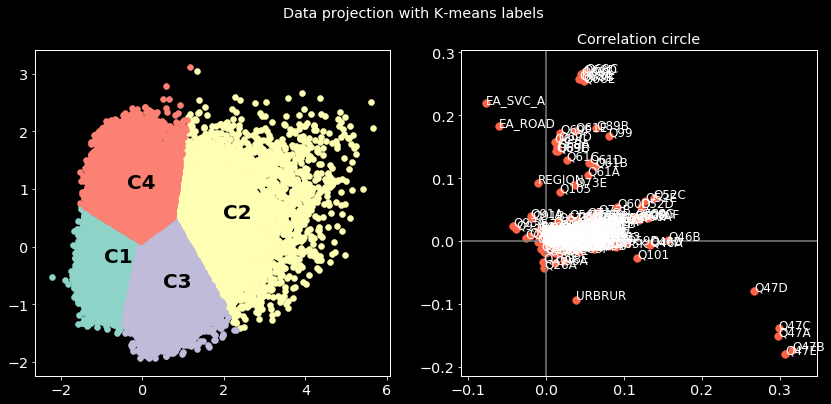

In [31]:
plot_2D(pca, pred_labs, 'Data projection with K-means labels')

We can note that the clusters have different size. C2 has the biggest one, C4 and 3 have approximately the same size and 
C1 the smallest one. Once we obtained the clusters we can compare them on some variables. Here I choosed to do the comparision on:
* Q1: Age
* Q101: Sex
* Q97: Education level
* Q61A to Q61F: type of experienced corruption
* COUNTRY_ALPHA: Countries

In [32]:
""" Defining a helper function for clusters comparision."""
def compare_clusters(df, k_means_labels, column, saveFig=True):
    """
    Inputs: 
        df: a pandas data frame
        k_means_labels: the obtained K-means labels
        column: A dictionary containing the column to plot and its label
        saveFig: A boolean for saving the figure or not, default value=True
    Outputs: This function don't have and outputs
    """
    fig = plt.figure(figsize=(12,6))
    col_key = list(column.keys())[0]
    col_val = list(column.values())[0]
    unique_labels = np.unique(k_means_labels)
    for i, lab in enumerate(unique_labels):
        ax = fig.add_subplot(2, 2, i + 1)
        if type(df) != pd.core.series.Series: 
            values = df.loc[k_means_labels == lab, col_key]
            # Creating a mask for dropping values 999, -1, 998.
            mask = (values != 999) & (values != -1) & (values != 998)
            values = values[mask] 
        else: values = df[k_means_labels == lab]
        
        if col_key == 'Q1': 
            values.plot(kind='box', ax=ax, color='orange')
            print('Mean age cluster {}: {}'.format(i + 1, np.round(values.mean(), 2)))
        elif col_key == 'Q101':
            count = values.map(encodeDict.SEX_DICTIONARY).value_counts()
            count.plot(kind='bar', ax=ax)
            plt.xticks(range(2), count.index, rotation='horizontal')
            annotate(count, ax, 'V')
        elif col_key == 'Q97':
            count = values.map(encodeDict.EDUCATION_DICTIONARY).value_counts()
            count.plot(kind='barh', ax=ax)
            annotate(count, ax, 'H')
        elif col_key == 'Q61F' or col_key=='Q61A' or col_key=='Q61B' or col_key == 'Q61C' or col_key == 'Q61D' or col_key == 'Q61E':
            count = values.map(encodeDict.RESPONSES_EXPERIENCE_WITH_BRIBERIES).value_counts()
            count.plot(kind='barh', ax=ax)
            annotate(count, ax, 'H')
        elif col_key == 'COUNTRY_ALPHA':
            count = values.map(encodeDict.COUNTRIES_DICTIONARY).value_counts()
            count.plot(kind='barh', ax=ax, figsize=(14,14))
            annotate(count, ax, 'H')
            
        ax.set_title('Cluster {}'.format(i + 1))
    fig.tight_layout()
    fig.suptitle(col_val, **FIGURE_SUPTITLE_PARAMS)
    if saveFig: savefig(fig, col_val)
    

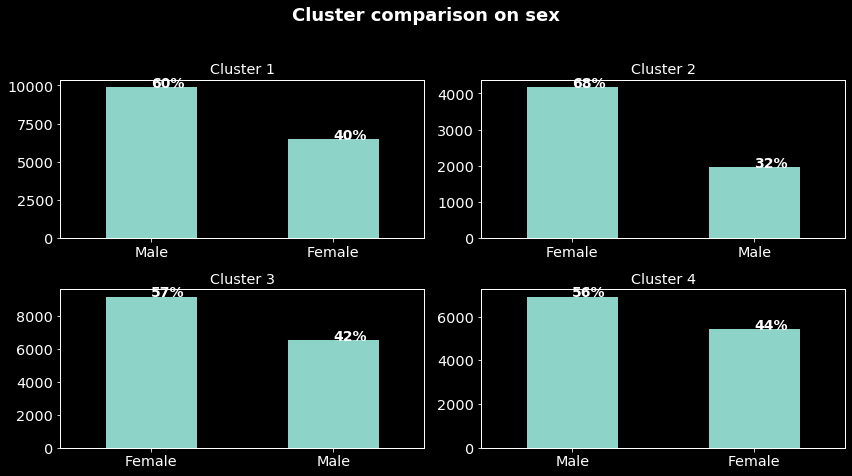

In [33]:
compare_clusters(df, pred_labs, {'Q101':'Cluster comparison on sex'})

Mean age cluster 1: 36.67
Mean age cluster 2: 40.22
Mean age cluster 3: 37.99
Mean age cluster 4: 35.59


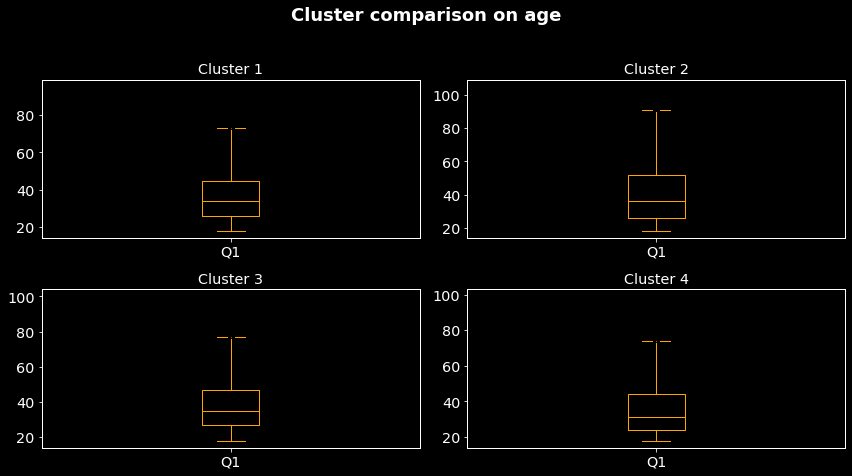

In [34]:
compare_clusters(df, pred_labs, {'Q1':'Cluster comparison on age'})

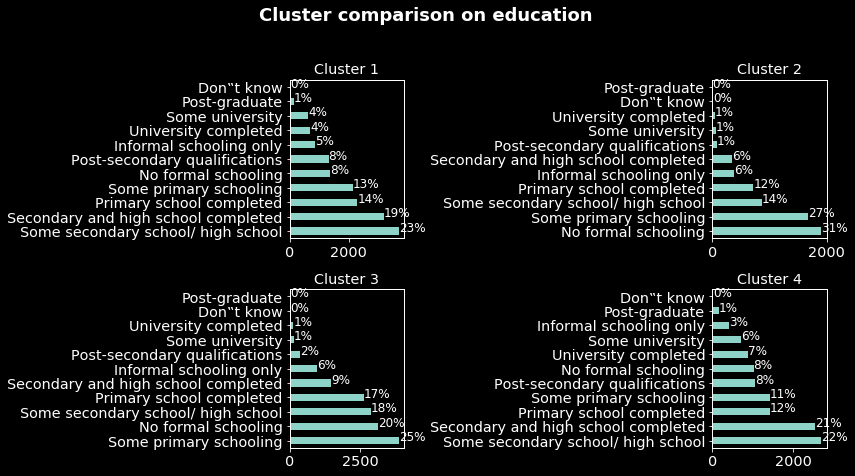

In [35]:
compare_clusters(df, pred_labs, {'Q97':'Cluster comparison on education'})

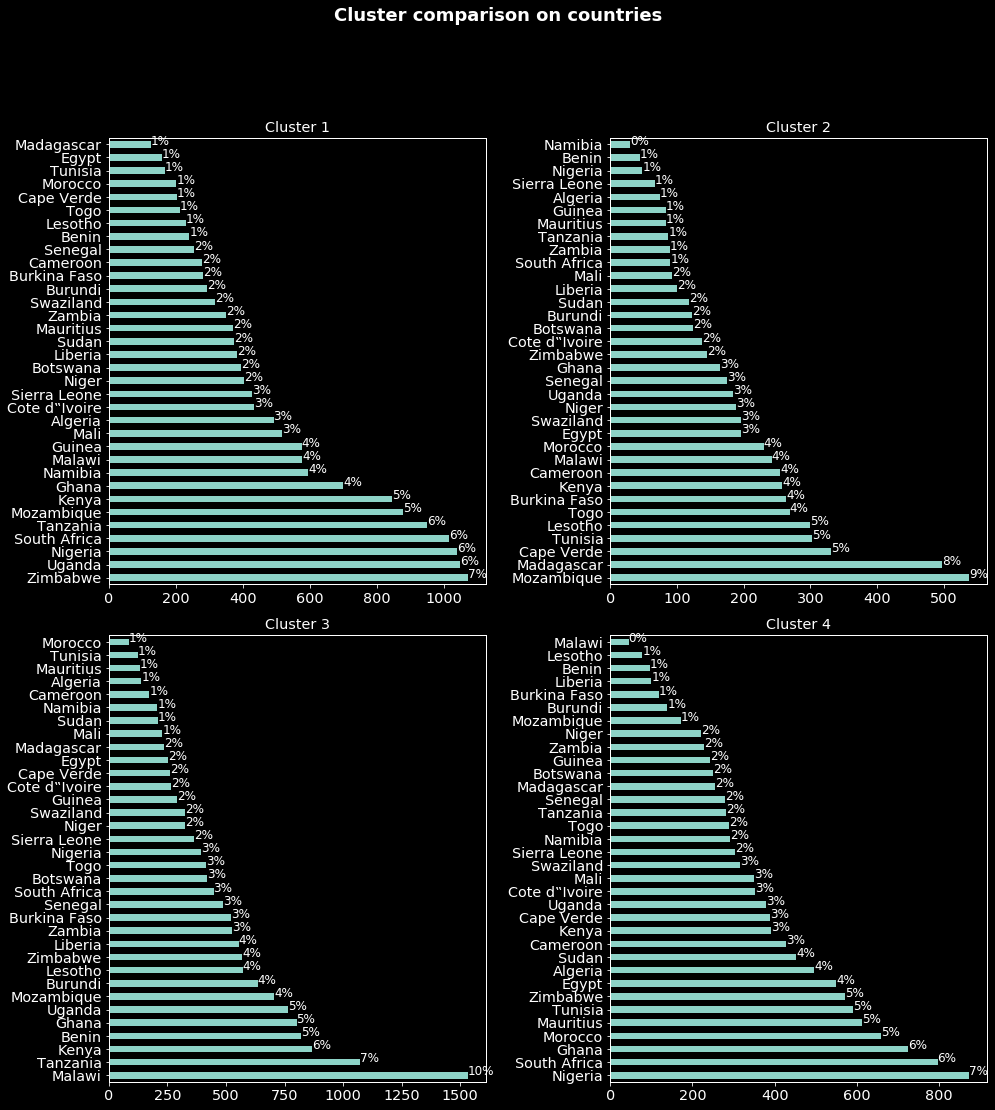

In [36]:
compare_clusters(df, pred_labs, {'COUNTRY_ALPHA':'Cluster comparison on countries'})

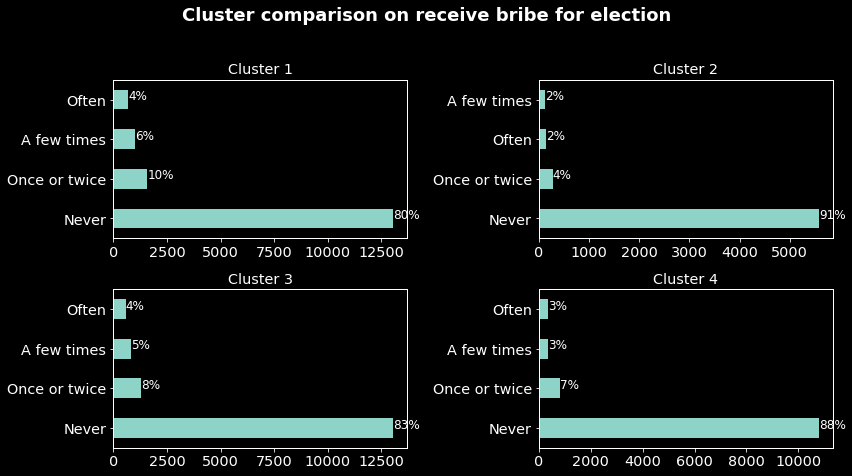

In [37]:
compare_clusters(target, pred_labs, {'Q61F':'Cluster comparison on receive bribe for election'})

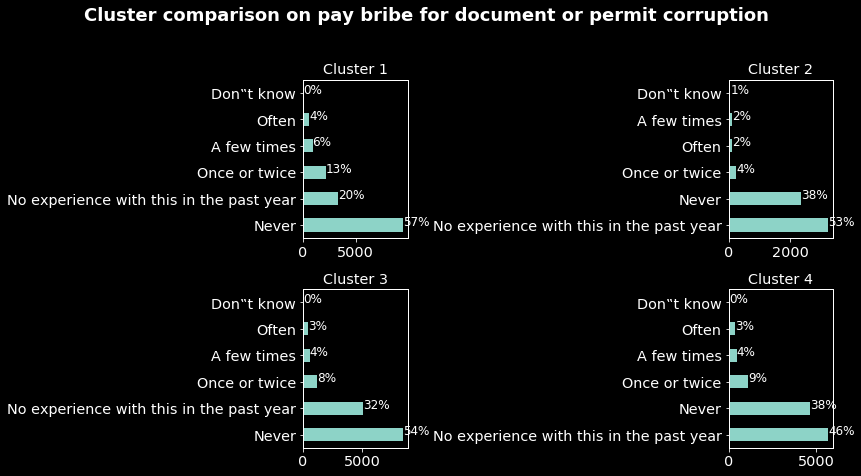

In [38]:
compare_clusters(df, pred_labs, {'Q61A':'Cluster comparison on pay bribe for document or permit corruption'})

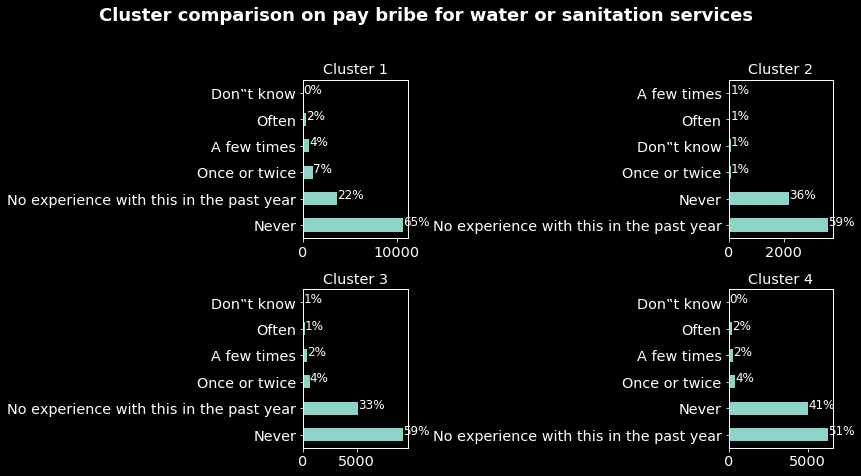

In [39]:
compare_clusters(df, pred_labs, {'Q61B':'Cluster comparison on pay bribe for water or sanitation services'})

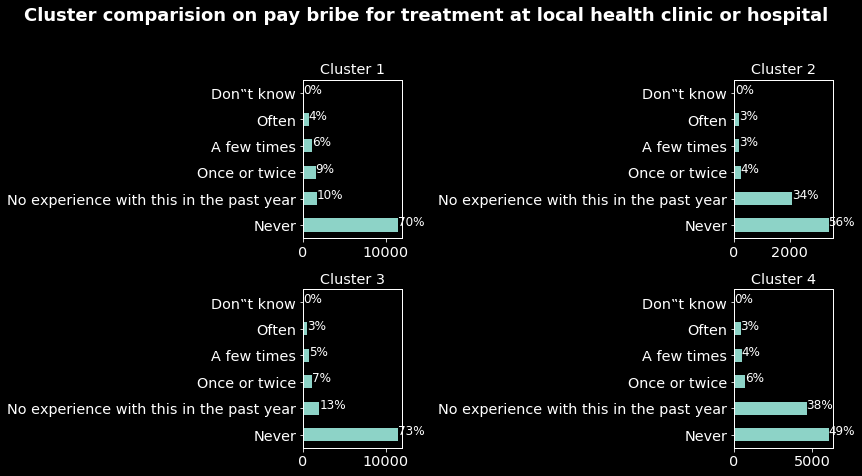

In [40]:
compare_clusters(df, pred_labs, {'Q61C':'Cluster comparision on pay bribe for treatment at local health clinic or hospital'})

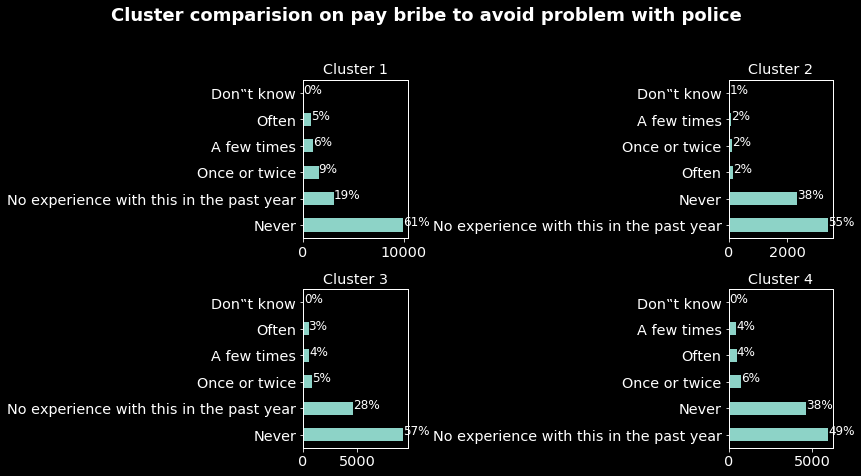

In [41]:
compare_clusters(df, pred_labs, {'Q61D':'Cluster comparision on pay bribe to avoid problem with police'})

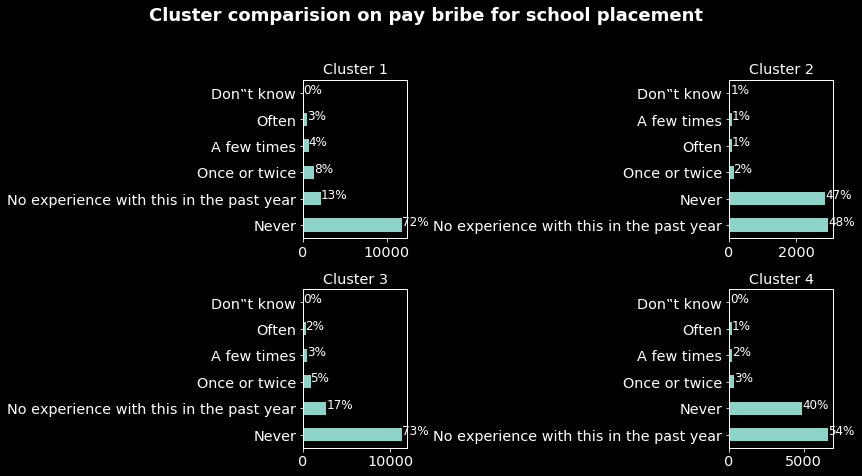

In [42]:
compare_clusters(df, pred_labs, {'Q61E':'Cluster comparision on pay bribe for school placement'})

# Supervised learning

## Importing packages for supervised learning

In [43]:
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from interpret.glassbox import ExplainableBoostingClassifier
import category_encoders as ce
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import time
from hyperopt import tpe
from sklearn.metrics import roc_auc_score
from hpsklearn import HyperoptEstimator, xgboost_classification, any_classifier, random_forest
RANDOM_STATE = 7

Using TensorFlow backend.


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


## Feature engineering

For the supervised learning, I used two common technics on categorical data:
* Counting: Which consist of creating new features by counting the frequences of unique values of each feature.
* Target encoding: Which consist of encoding the data using the target variable.

In [44]:
"""Defining a helper function for count encoding"""
def count_encoding(df):
    """
    Input: 
        df: a pandas data frame
    Output:
        a pandas data frame with old and new created features
    """
    for col in list(df):
        counts = df[col].value_counts()
        df[col + '_count'] = df[col].map(counts)
    return df

def target_encode(df, target):
    """
    Input: 
        df: a pandas data frame
        target: the target variable
    Output:
        a pandas data frame which contains transformed features
    """
    encoder = ce.TargetEncoder(cols=list(df))
    encoder.fit(df, target)
    df_targ_enc = encoder.transform(df)
    return df_targ_enc

In [45]:
df_count_encode = count_encoding(df.copy())
df_targ_encoded = target_encode(df_count_encode, target_2_classes)

In [46]:
df_targ_encoded.head()

,COUNTRY_ALPHA,URBRUR,REGION,EA_SVC_A,EA_SVC_B,EA_SVC_C,EA_SVC_D,EA_FAC_A,EA_FAC_B,EA_FAC_C,...,Q97_count,Q98A_count,Q98B_count,Q99_count,Q100_count,Q101_count,Q102_count,Q103_count,Q104_count,Q105_count
0,0.038365,0.179585,0.02,0.138405,0.192636,0.1729,0.159615,0.169369,0.164463,0.1644,...,0.157088,0.156541,0.184615,0.005208,0.149251,0.171847,0.121099,0.119945,0.148175,0.107947
1,0.038365,0.179585,0.02,0.138405,0.192636,0.1729,0.159615,0.169369,0.164463,0.1644,...,0.157088,0.156541,0.184615,0.035211,0.184353,0.146162,0.121099,0.119945,0.169278,0.107947
2,0.038365,0.179585,0.02,0.138405,0.192636,0.1729,0.159615,0.169369,0.164463,0.1644,...,0.157088,0.147521,0.184615,0.148148,0.165464,0.171847,0.121099,0.119945,0.146341,0.098830
3,0.038365,0.179585,0.02,0.138405,0.192636,0.1729,0.159615,0.169369,0.164463,0.1644,...,0.186170,0.156541,0.184615,0.118799,0.130435,0.146162,0.121099,0.119945,0.146341,0.098830
4,0.038365,0.179585,0.02,0.138405,0.192636,0.1729,0.159615,0.169369,0.164463,0.1644,...,0.152663,0.156541,0.155778,0.164650,0.162133,0.171847,0.121099,0.119945,0.169278,0.129293


## Splitting the data into train and validation sets

In [47]:
"""Helper function for splitting the data into a train and test sets giving a test set size"""
def split(df, target, test_size=0.3):
    """
    Inputs: 
        df: a pandas data frame
        target: the target variable
        test_size: the size of the test set
    Outputs:
        x_train: the training data
        x_val: the validation data
        y_train: the training label
        y_val: the validation labe
    """
    x_train, x_val, y_train, y_val = train_test_split(df, target, shuffle=True, random_state=10)
    return x_train, x_val, y_train, y_val

In [48]:
x_train, x_val, y_train, y_val = split(df_targ_encoded, target_2_classes)

In [49]:
"""
Factorized (common) code for the classes below.
This function some attributes of the classes below.
"""
def initialize_attributes(self_, x_train, x_val, y_train, y_val):
    """
    Inputs: 
        self_: A class instance
        x_train: the training data
        x_val: the validation data
        y_train: the training label
        y_val: the validation label
    Outputs:
        self_
    """
    self_.x_train = x_train
    self_.x_val = x_val
    self_.y_train = y_train
    self_.y_val = y_val
    return self_
 
"""
Defining a function for creating data for semi-supervised learning.
The process is the following:
Given the predictions of a model and a threshold, we compute the indexes of the predictions
having a value greater or equal to the threshold and we append the validation data corresponding to the
computed indexes to the training set.
"""    
def get_semi_supervised_data(x_train, x_val, y_train, y_val, preds_prob, threshold):
    preds = pd.Series(preds_prob)
    mask = (preds >= threshold).values
    indexes = y_val[mask].index
    x_train_new = pd.concat([x_train, x_val.loc[indexes]])
    y_train_new = np.append(y_train, y_val[indexes])
    return x_train_new, y_train_new

"""Defining a class for neural nets models"""
class NeuralNets:
    """
    This class help to perfom a deep learning supervised and semi-supervised learning.
    """
    def __init__(self, x_train, x_val, y_train, y_val):
        self = initialize_attributes(self, x_train, x_val, y_train, y_val)
        self.preds_prob = []
    
    """Helper function for supervised learning"""
    def supervised_learning(self):
        """
        Deep learning type of model: Keras Sequential
        Architecture:
            First layer: dimension of x_train, activation: relu, kernel initializer: randnormal
            hidden layers:
                1: units:100, activation: relu, kernel initializer: randnormal, dropout:0.4
                2. units:100, activation: relu, kernel initializer: randnormal, dropout:0.2
            Output layer: units:2, activation: softmax
        """
        y = pd.get_dummies(pd.Series(self.y_train).astype('category'))
        y_val = pd.get_dummies(pd.Series(self.y_val).astype('category'))
        
        callback = EarlyStopping(patience=5)
        initializer = RandomNormal(seed=RANDOM_STATE)
        
        model = Sequential()
        model.add(Dense(units=100, input_shape=(self.x_train.shape[1], ), activation='relu', kernel_initializer=initializer))
        model.add(Dropout(0.4))
        model.add(Dense(100, activation='relu', kernel_initializer=initializer))
        model.add(Dropout(0.2))
        model.add(Dense(2, activation='softmax', kernel_initializer=initializer))

        model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(self.x_train, y, epochs=20, callbacks=[callback], verbose=0, validation_data=(self.x_val, y_val))
        self.preds_prob = model.predict(self.x_val)[:, 1]
        auc = np.round(roc_auc_score(self.y_val, self.preds_prob), 2)
        print('Auc:', auc)
        return self.preds_prob, auc,'_', '_'
    
    """Defining a helper function for semi-supervised learning"""
    def semi_supervised_learning(self, threshold=0.9):
        """
        Inputs: 
            threshold: the threshold of predictions of the training data which will be used 
                        to append some validation data to the training one.
        """
        self.x_train, self.y_train = get_semi_supervised_data(self.x_train, self.x_val,
                                                self.y_train, self.y_val, self.preds_prob, threshold)
        return self.supervised_learning()

In [50]:
"""
Defining a class for performing supervised and semi-supervised learning for non deep learning 
models.
"""
class Model:
    def __init__(self, model, x_train, x_val, y_train, y_val):
        self = initialize_attributes(self, x_train, x_val, y_train, y_val)
        self.model = model
        self.preds = []
        self.preds_prob = []
    
    def fit(self, params=None):
        if params != None: self.model.fit(self.x_train, self.y_train, **params)
        else: self.model.fit(self.x_train, self.y_train)
        return self
    
    def predict(self):
        self.preds = self.model.predict(self.x_val)
        self.preds_prob = self.model.predict_proba(self.x_val)[:, 1]
        
        
    def fit_predict(self):
        self.fit()
        self.predict()
        return self
    
    def scores(self):
        acc = np.round(accuracy_score(self.y_val, self.preds), 2)
        recall = np.round(recall_score(self.y_val, self.preds, average=None), 2)
        auc = np.round(roc_auc_score(self.y_val, self.preds_prob), 2)
        print('Accuracy:', acc)
        print('Recall:', recall)
        print('AUC:', auc)
        return acc, recall, auc
    
    def supervised_learning(self):
        self.fit_predict()
        acc, recall, auc = self.scores()
        return self.preds_prob, acc, recall, auc
    
    def semi_supervised_learning(self, threshold=0.9):
        self.x_train, self.y_train = get_semi_supervised_data(self.x_train, self.x_val,
                                                self.y_train, self.y_val, self.preds_prob, threshold)
        preds_prob, acc, recall, auc = self.supervised_learning()
        return preds_prob, acc, recall, auc

In [51]:
class Classification:
    def __init__(self, list_models, x_train, x_val, y_train, y_val):
        self = initialize_attributes(self, x_train, x_val, y_train, y_val)
        self.list_models = list_models
        self.list_Models = {}
    
    def get_vars(self):
        preds = {}
        df_scores = pd.DataFrame(columns=['Accuracy', 'Recall', 'AUC', 'Execution time (s)'],
                                 index=list(self.list_models.keys()))
        recall = '_'
        acc = '_'
        return preds, df_scores, recall, acc
    
    def run_supervised_learning(self):
        preds, df_scores, recall, acc= self.get_vars()
        for i, (model_name, model) in enumerate(self.list_models.items()):
            print('\n' + model_name)
            if model_name != 'Neural Nets':
                model_ = Model(model, x_train, x_val, y_train, y_val)
            else: model_ = model
            time_start = time.time()
            preds_prob, acc, recall, auc = model_.supervised_learning()
            time_end = time.time()

            execution_time = time_end - time_start 
            df_scores.loc[model_name, :] = [acc, recall, auc, execution_time]
            preds[model_name] = preds_prob
            self.list_Models[model_name] = model_
        return df_scores , preds
    
    def run_semi_supervised_learning(self, threshold=0.9):
        preds, df_scores, recall, acc= self.get_vars()
        for model_name, model_ in self.list_Models.items():
            print('\n' + model_name)
            time_start = time.time()
            preds_prob, acc, recall, auc = model_.semi_supervised_learning(threshold)
            time_end = time.time()
            execution_time = time_end - time_start 
            df_scores.loc[model_name, :] = [acc, recall, auc, execution_time]
            preds[model_name] = preds_prob
        return df_scores , preds

In [52]:
# Some attributes are common the models, we set them into a dictionary
models_common_params_GBM = dict(random_state=RANDOM_STATE, verbose=0)

## Defining models

We will be using 6 models:
* LightGBM
* XGBoost
* CatBoost
* 2 layers Neural Nets
* Explainable Boosting Classifier
* Hist Gradient Boosting Classifier

In [53]:
clf_lgb = lgb.LGBMClassifier(**models_common_params_GBM)    
clf_xgb = xgb.XGBClassifier(**models_common_params_GBM)
clf_cat = cat.CatBoostClassifier(**models_common_params_GBM)
nn = NeuralNets(x_train, x_val, y_train, y_val)
clf_int = ExplainableBoostingClassifier(random_state=RANDOM_STATE)
clf_hist = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
list_models = {'LightGBM':clf_lgb, 'XGBoost':clf_xgb, 'CatBoost':clf_cat, 'Neural Nets':nn, 
               'Explainable Boosting':clf_int, 'Hist Gradient Boosting':clf_hist}

In [54]:
# Defining an instance of the classification class 
classifiers = Classification(list_models, x_train, x_val, y_train, y_val)

## Supervised learning

In [55]:
df_scores_supLearning, prediction_supLearning = classifiers.run_supervised_learning()


LightGBM
Accuracy: 0.88
Recall: [0.97 0.41]
AUC: 0.87

XGBoost
Accuracy: 0.87
Recall: [0.97 0.33]
AUC: 0.86

CatBoost
Accuracy: 0.88
Recall: [0.97 0.41]
AUC: 0.87

Neural Nets




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Auc: 0.85

Explainable Boosting
Accuracy: 0.87
Recall: [0.97 0.33]
AUC: 0.85

Hist Gradient Boosting
Accuracy: 0.88
Recall: [0.97 0.4 ]
AUC: 0.87


In [56]:
df_scores_supLearning

,Accuracy,Recall,AUC,Execution time (s)
LightGBM,0.88,"[0.97, 0.41]",0.87,4.31105
XGBoost,0.87,"[0.97, 0.33]",0.86,29.041
CatBoost,0.88,"[0.97, 0.41]",0.87,77.169
Neural Nets,0.85,_,_,39.6629
Explainable Boosting,0.87,"[0.97, 0.33]",0.85,354.126
Hist Gradient Boosting,0.88,"[0.97, 0.4]",0.87,13.5446


## Semi supervised learning

In [57]:
df_scores_supLearning, prediction_supLearning = classifiers.run_semi_supervised_learning()


LightGBM
Accuracy: 0.88
Recall: [0.97 0.4 ]
AUC: 0.87

XGBoost
Accuracy: 0.87
Recall: [0.97 0.33]
AUC: 0.86

CatBoost
Accuracy: 0.88
Recall: [0.97 0.41]
AUC: 0.87

Neural Nets
Auc: 0.85

Explainable Boosting
Accuracy: 0.87
Recall: [0.97 0.33]
AUC: 0.85

Hist Gradient Boosting
Accuracy: 0.88
Recall: [0.97 0.4 ]
AUC: 0.87


In [58]:
df_scores_supLearning

,Accuracy,Recall,AUC,Execution time (s)
LightGBM,0.88,"[0.97, 0.4]",0.87,12.5134
XGBoost,0.87,"[0.97, 0.33]",0.86,28.7541
CatBoost,0.88,"[0.97, 0.41]",0.87,78.0328
Neural Nets,0.85,_,_,39.7249
Explainable Boosting,0.87,"[0.97, 0.33]",0.85,343.896
Hist Gradient Boosting,0.88,"[0.97, 0.4]",0.87,14.3278
